In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 29kB/s 
     |████████████████████████████████| 6.5MB 64.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
#from models.inception_resnet_v1 import InceptionResnetV1import cv2
import cv2
from PIL import Image
from pdb import set_trace
import time
#import copyfrom pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
#import dlib
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
!cp '/content/drive/My Drive/eva4_phase2_datasets/data_after_mtcnn.zip' .

In [6]:
!unzip -qq data_after_mtcnn.zip

In [7]:
!ls data

test_me


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(160),
        transforms.RandomCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(160),
        transforms.RandomCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/data/test_me'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Amitav',
 'Ananya',
 'AnilKapoor',
 'BillGates',
 'ElonMusk',
 'LaluYadav',
 'LionelMessi',
 'MichaelJordan',
 'Obama',
 'TomHanks']

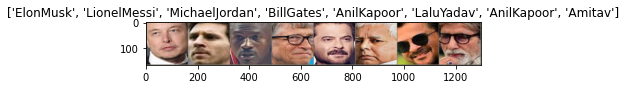

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)

use_cuda:  True


In [11]:
device = torch.device("cuda" if use_cuda else "cpu")

In [12]:
! pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 9.1MB/s 


In [13]:
from facenet_pytorch import  InceptionResnetV1
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

In [14]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [15]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [16]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [17]:
for param in model_ft.parameters():
    param.requires_grad = False

In [18]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [19]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

In [20]:
import copy
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                 model.eval()   # Set model to evaluate mode         
            running_loss = 0.0
            running_corrects = 0            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                # zero the parameter gradients
                optimizer.zero_grad()                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/99
----------
train Loss: 2.3030 Acc: 0.1000
val Loss: 2.3011 Acc: 0.2800
Epoch 1/99
----------
train Loss: 2.2997 Acc: 0.3438
val Loss: 2.2975 Acc: 0.6200
Epoch 2/99
----------
train Loss: 2.2964 Acc: 0.6813
val Loss: 2.2954 Acc: 0.7400
Epoch 3/99
----------
train Loss: 2.2954 Acc: 0.7688
val Loss: 2.2950 Acc: 0.8200
Epoch 4/99
----------
train Loss: 2.2948 Acc: 0.7875
val Loss: 2.2945 Acc: 0.8400
Epoch 5/99
----------
train Loss: 2.2947 Acc: 0.8125
val Loss: 2.2945 Acc: 0.8200
Epoch 6/99
----------
train Loss: 2.2946 Acc: 0.7812
val Loss: 2.2946 Acc: 0.8600
Epoch 7/99
----------
train Loss: 2.2944 Acc: 0.8125
val Loss: 2.2945 Acc: 0.8400
Epoch 8/99
----------
train Loss: 2.2948 Acc: 0.7750
val Loss: 2.2945 Acc: 0.8400
Epoch 9/99
----------
train Loss: 2.2945 Acc: 0.8125
val Loss: 2.2945 Acc: 0.8200
Epoch 10/99
----------
train Loss: 2.2943 Acc: 0.8438
val Loss: 2.2944 Acc: 0.8400
Epoch 11/99
----------
train Loss: 2.2944 Acc: 0.8375
val Loss: 2.2945 Acc: 0.8400
Epoch 12/99
--

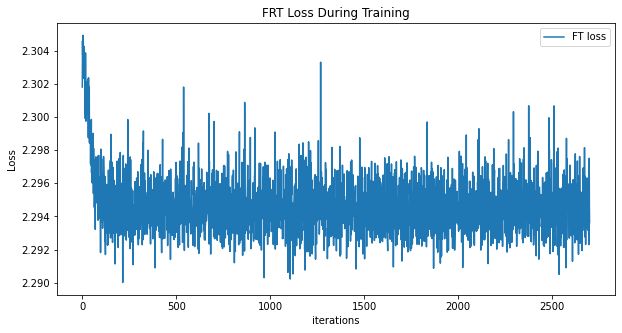

In [21]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
MODEL_PATH = '/content/drive/My Drive/eva4_phase2_apis/model_facenet_latest.pt'
model_cpu = model_ft.to('cpu')
traced_model = torch.jit.trace(model_cpu, torch.randn(1,3, 224, 224))
traced_model.save(MODEL_PATH)